## Predicting heart disease using ML
Data contains:

*  age - age in years
* sex - (1 = male; 0 = female)
* cp - chest pain type
* trestbps - resting blood pressure (in mm Hg on admission to the hospital)
* chol - serum cholestoral in mg/dl
* fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
* restecg - resting electrocardiographic results
* thalach - maximum heart rate achieved
* exang - exercise induced angina (1 = yes; 0 = no)
* oldpeak - ST depression induced by exercise relative to rest
* slope - the slope of the peak exercise ST segment
* ca - number of major vessels (0-3) colored by flourosopy
* thal - 3 = normal; 6 = fixed defect; 7 = reversable defect
* target - have disease or not (1=yes, 0=no)

## Preparing the tools

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

#Model evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

## Load Data

In [3]:
df = pd.read_csv("heart.csv")
df.shape

(303, 14)

## Data Exploration (EDA)
The goal here is to find more about the data
1. what are we trying to do?
2. What kind of data do we have
3. what is missing
4. Where are the outliers and why should you care about them
5. How can you add, change or remove features

In [4]:
df.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0
302,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


In [5]:
# find out how many of each class they are
df["target"].value_counts()

1    165
0    138
Name: target, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [7]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [8]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


C:\Users\jackl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


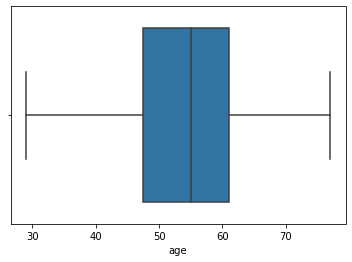

In [9]:
#Identify any presence of outliers in the continuous features and resolve them using the IQR method._age

def remove_outlier(col):
    q25 = col.quantile(0.25)
    q75 = col.quantile(0.75)
    iqr = q75 - q25
    cutoff = iqr*1.5
    lower = q25 - cutoff
    upper = q75 + cutoff
    return lower, upper

lower, upper = remove_outlier(df.age)

df = df.loc[(df.age > lower) & (df.age < upper)]

sns.boxplot(df.age);

C:\Users\jackl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


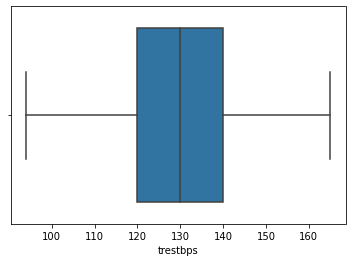

In [10]:
#Identify any presence of outliers in the continuous features and resolve them using the IQR method._trestbps

def remove_outlier(col):
    q25 = col.quantile(0.25)
    q75 = col.quantile(0.75)
    iqr = q75 - q25
    cutoff = iqr*1.5
    lower = q25 - cutoff
    upper = q75 + cutoff
    return lower, upper

lower, upper = remove_outlier(df.trestbps)

df = df.loc[(df.trestbps > lower) & (df.trestbps < upper)]

sns.boxplot(df.trestbps);

C:\Users\jackl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


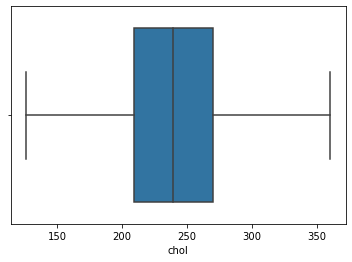

In [11]:
#Identify any presence of outliers in the continuous features and resolve them using the IQR method._chol

def remove_outlier(col):
    q25 = col.quantile(0.25)
    q75 = col.quantile(0.75)
    iqr = q75 - q25
    cutoff = iqr*1.5
    lower = q25 - cutoff
    upper = q75 + cutoff
    return lower, upper

lower, upper = remove_outlier(df.chol)

df = df.loc[(df.chol > lower) & (df.chol < upper)]

sns.boxplot(df.chol);

C:\Users\jackl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


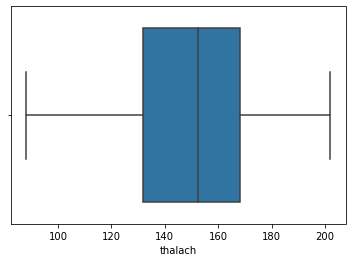

In [12]:
#Identify any presence of outliers in the continuous features and resolve them using the IQR method._thalach

def remove_outlier(col):
    q25 = col.quantile(0.25)
    q75 = col.quantile(0.75)
    iqr = q75 - q25
    cutoff = iqr*1.5
    lower = q25 - cutoff
    upper = q75 + cutoff
    return lower, upper

lower, upper = remove_outlier(df.thalach)

df = df.loc[(df.thalach > lower) & (df.thalach < upper)]

sns.boxplot(df.thalach);

C:\Users\jackl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


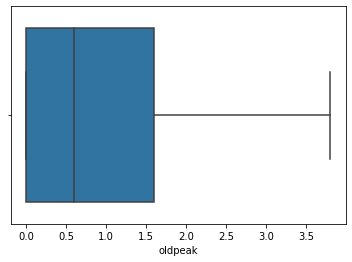

In [13]:
#Identify any presence of outliers in the continuous features and resolve them using the IQR method._oldpeak

def remove_outlier(col):
    q25 = col.quantile(0.25)
    q75 = col.quantile(0.75)
    iqr = q75 - q25
    cutoff = iqr*1.5
    lower = q25 - cutoff
    upper = q75 + cutoff
    return lower, upper

lower, upper = remove_outlier(df.oldpeak)

df = df.loc[(df.oldpeak > lower) & (df.oldpeak < upper)]

sns.boxplot(df.oldpeak);

In [14]:
# Binned the continuous column values apart from the column ‘oldpeak’.
df['age_binned'] = pd.qcut(df.age, q=[0, .25, .50, .75, 1])
df['chol_binned']= pd.qcut(df.chol, q=[0, .25, .50, .75, 1])
df['thalach_binned']= pd.qcut(df.thalach, q=[0, .25, .50, .75, 1])

## 5.9 Modelling

In [25]:
# split data into x and y
X= df.drop(columns = ["target", 'age_binned', 'chol_binned', 'thalach_binned'], axis= 1)
y= df['target']

In [26]:
X

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3


In [27]:
y

0      1
1      1
2      1
3      1
4      1
      ..
298    0
299    0
300    0
301    0
302    0
Name: target, Length: 279, dtype: int64

In [28]:
# split data into train andf test set
np.random.seed(42)
X_train, X_test, y_train, y_test=  train_test_split(X, y, test_size= 0.2)

In [29]:
X_train

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
282,59,1,2,126,218,1,1,134,0,2.2,1,1,1
130,54,0,2,160,201,0,1,163,0,0.0,2,1,2
35,46,0,2,142,177,0,0,160,1,1.4,0,0,2
89,58,0,0,100,248,0,0,122,0,1.0,1,0,2
286,59,1,3,134,204,0,1,162,0,0.8,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,46,1,2,150,231,0,1,147,0,3.6,1,0,2
73,51,1,0,140,261,0,0,186,1,0.0,2,0,2
112,64,0,2,140,313,0,1,133,0,0.2,2,0,3
293,67,1,2,152,212,0,0,150,0,0.8,1,0,3


In [30]:
y_train

282    0
130    1
35     1
89     1
286    0
      ..
196    0
73     1
112    1
293    0
107    1
Name: target, Length: 223, dtype: int64

1. Data is split, now build a machine learning model, find the patterns on the traiing set, use the patterns on the test set
2. 


In [33]:
# put models in a dictionary
models= {"Logistic Regression": LogisticRegression(), 
        "KNN": KNeighborsClassifier(),
        "Random Forest": RandomForestClassifier()}

# Create a function to fit and score models
def fit_and_score (models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models: a dict of different sklearn machine learning models
    X_train : training data (no labels)
    X_test : testing data (no labels)
    y_train : training labels
    y_test : test labels
    """
    # set random seed
    np.random.seed(42)
    # make a dict to keep model scores
    model_scores = {}
    #loop through models
    for name, model in models.items():
        #fit model to the data
        model.fit(X_train, y_train)
        #evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores
        

In [34]:
model_scores= fit_and_score(models= models,
                           X_train = X_train,
                           X_test= X_test,
                           y_train = y_train,
                           y_test = y_test
                          )
model_scores

C:\Users\jackl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'Logistic Regression': 0.8392857142857143,
 'KNN': 0.6607142857142857,
 'Random Forest': 0.8392857142857143}

In [32]:
X_train.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
dtype: object

## Model Comparison

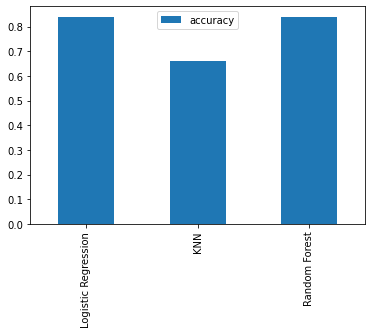

In [35]:
model_compare = pd.DataFrame(model_scores, index = ["accuracy"])
model_compare.T.plot.bar();

Let's look at the following: 
* Hyperparameter tuning
* Feature Importance
* confusion matrix
* Cross-validation
* Precision
* Recall
* F1 score
* ROC
* AUC

## Hyperparemeter tuning

In [36]:
# lets tune knn
train_score = []
test_score= []

# create a list of different values for n neighbors
neighbors = range (1, 21)
 # set up knn instance
knn = KNeighborsClassifier()
    
#loop
for i in neighbors:
    knn.set_params(n_neighbors =i)
    
    #Fit the algorithm
    knn.fit( X_train, y_train)
    # update
    train_score.append(knn.score(X_train, y_train))
    # update the test score list
    test_score.append(knn.score(X_test, y_test))


In [37]:
train_score

[1.0,
 0.7757847533632287,
 0.7623318385650224,
 0.7399103139013453,
 0.7757847533632287,
 0.757847533632287,
 0.7309417040358744,
 0.7130044843049327,
 0.7040358744394619,
 0.6860986547085202,
 0.695067264573991,
 0.6905829596412556,
 0.6860986547085202,
 0.695067264573991,
 0.7085201793721974,
 0.7040358744394619,
 0.6995515695067265,
 0.695067264573991,
 0.6771300448430493,
 0.6860986547085202]

In [38]:
test_score

[0.6964285714285714,
 0.6428571428571429,
 0.75,
 0.6607142857142857,
 0.6607142857142857,
 0.625,
 0.6428571428571429,
 0.625,
 0.6785714285714286,
 0.6071428571428571,
 0.6785714285714286,
 0.6071428571428571,
 0.6428571428571429,
 0.5892857142857143,
 0.5892857142857143,
 0.6428571428571429,
 0.6785714285714286,
 0.6428571428571429,
 0.6428571428571429,
 0.6428571428571429]

Maximum KNN score on the test data: 75.00%


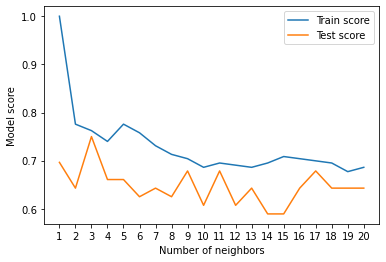

In [39]:
plt.plot(neighbors, train_score, label= "Train score")
plt.plot (neighbors, test_score, label= "Test score")
plt.xticks(np.arange(1, 21,1))
plt.xlabel ('Number of neighbors')
plt.ylabel("Model score")        
plt.legend()

print (f"Maximum KNN score on the test data: {max(test_score)*100:.2f}%")

## Hyperparameter tuning with RandomizedSearchCV

We are going to tune
* Logistic regression model
* Random forest classifier

... using RSCV


In [40]:
# Create a hyperparameter grid
log_reg_grid = {'C': np.logspace (-4,4, 20), 
               'solver': ["liblinear"]}

# create hyperparameter grid for random forest classifier
rf_grid = {'n_estimators': np.arange(10, 1000, 50), 
          "max_depth": ["None", 3, 5, 10],
          "min_samples_split": np.arange (2,20,2),
          'min_samples_leaf': np.arange (1,20, 2)
          }

In [41]:
# tune  losgistic regression
np.random.seed(42)

# hyperparameter search for logreg
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                               param_distributions = log_reg_grid,
                               cv = 5,
                               n_iter =20,
                               verbose= True)

# Fit random hyperparameter search for logreg
rs_log_reg.fit (X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [42]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 0.08858667904100823}

In [43]:
rs_log_reg.score(X_test, y_test)

0.8214285714285714

Now we tune logreg(), do the same for Random forest classifire

In [44]:
# set up random seed
np.random.seed(42)

# hyperparameter search for RandomForestClassifier
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                               param_distributions = rf_grid,
                               cv = 5,
                               n_iter =20,
                               verbose= True)

# Fit random hyperparameter search for logreg
rs_rf.fit (X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\jackl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jackl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jackl\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jackl\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jackl\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\jackl\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

C:\Users\jackl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jackl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jackl\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jackl\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jackl\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\jackl\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

C:\Users\jackl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jackl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jackl\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jackl\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jackl\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\jackl\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

C:\Users\jackl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jackl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jackl\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jackl\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jackl\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\jackl\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

C:\Users\jackl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jackl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jackl\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jackl\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jackl\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\jackl\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

C:\Users\jackl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jackl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jackl\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\jackl\anaconda3\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jackl\anaconda3\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\jackl\anaconda3\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

C:\Users\jackl\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.81181818 0.81181818 0.81181818 0.80282828 0.80737374
 0.81636364 0.82979798        nan 0.81626263 0.82070707 0.79828283
 0.82090909 0.79828283 0.81171717 0.81181818        nan        nan
        nan 0.80727273]
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': ['None', 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [45]:
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [46]:
rs_rf.best_params_

{'n_estimators': 260,
 'min_samples_split': 16,
 'min_samples_leaf': 9,
 'max_depth': 10}

In [47]:
rs_rf.score(X_test, y_test)

0.875

## Tune the hyperparameters using GridSearchCV

In [48]:
# Different hyperparamters for our LogReg
log_reg_grid = { "C": np.logspace (-4, 4, 30),
               "solver": ["liblinear"]}

# setup hyperparameter for the LogisticRegression
gs_log_reg = GridSearchCV (LogisticRegression(),
                           param_grid = log_reg_grid,
                           cv= 5,
                           verbose = True)
# Fit grid hyperparameter search model
gs_log_reg.fit (X_train, y_train);

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [49]:
gs_log_reg.best_params_

{'C': 0.20433597178569418, 'solver': 'liblinear'}

In [50]:
# Evaluate the grisearch logreg model
gs_log_reg.score (X_test, y_test)

0.8392857142857143

## create our tunes ML classifier, beyond accuracy
* ROC Curve and AUC score
* Confusion matrix
* classificatio report
* Precision
*Recall
*F1 score

In [51]:
# make predictions with tuned model
y_preds = gs_log_reg.predict(X_test)

In [52]:
y_preds

array([1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1], dtype=int64)

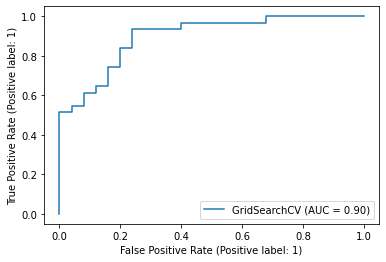

In [53]:
# Plot ROC curve and calculate AUC metric
plot_roc_curve(gs_log_reg, X_test, y_test);

In [54]:
# confusion matrix
print(confusion_matrix(y_test, y_preds))

[[19  6]
 [ 3 28]]


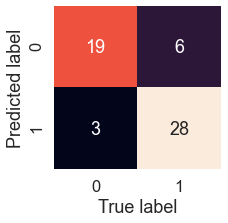

In [55]:
sns.set(font_scale= 1.5)

def plot_conf_mat (y_test, y_preds):
    fig, ax = plt.subplots (figsize =(3,3))
    ax= sns.heatmap(confusion_matrix(y_test, y_preds),
                    annot= True,
                    cbar = False)
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    
    
plot_conf_mat(y_test, y_preds)
    

In [56]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.86      0.76      0.81        25
           1       0.82      0.90      0.86        31

    accuracy                           0.84        56
   macro avg       0.84      0.83      0.84        56
weighted avg       0.84      0.84      0.84        56



 ### Calculate evaluation metrics using cross-validation
    
calculating precision, recall and F1 score using corss- validation

In [57]:
# check best hyperparameters
gs_log_reg.best_params_

{'C': 0.20433597178569418, 'solver': 'liblinear'}

In [58]:
clf= LogisticRegression(C= 0.20433597178569418, solver= 'liblinear' )

In [59]:
 # cross-validated accuracy
from sklearn.model_selection import cross_val_score
cv_acc= cross_val_score(clf,
                       X,
                       y,
                       cv= 5,
                       scoring ="accuracy")
cv_acc

array([0.85714286, 0.82142857, 0.92857143, 0.875     , 0.70909091])

In [60]:
cv_acc= np.mean(cv_acc)
cv_acc

0.8382467532467531

In [61]:
# cross-validated precision
cv_precision= cross_val_score(clf,
                       X,
                       y,
                       cv= 5,
                       scoring ="precision")
cv_precision = np.mean (cv_precision)
cv_precision

0.8204919822179884

In [62]:
# cross-validated recall
cv_recall= cross_val_score(clf,
                       X,
                       y,
                       cv= 5,
                       scoring ="recall")
cv_recall = np.mean (cv_recall)
cv_recall

0.923991935483871

In [63]:
#cross-validated F1-score
cv_f1= cross_val_score(clf,
                       X,
                       y,
                       cv= 5,
                       scoring ="f1")
cv_f1 = np.mean (cv_f1)
cv_f1

0.8677300187374815

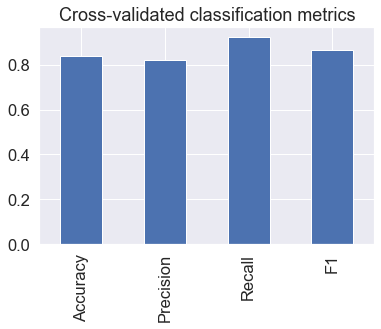

In [64]:
 #visualize cros-validated matrix
cv_metrics = pd.DataFrame ({'Accuracy': cv_acc,
                               'Precision': cv_precision,
                               "Recall": cv_recall,
                               "F1": cv_f1},
                              index =[0])

cv_metrics.T.plot.bar(title ='Cross-validated classification metrics',
                     legend = False);
    

## Feature Importance

Asking which features contributed the the outcome of the model

In [65]:
# Fit an instance of LogisitcRegression
gs_log_reg.best_params_
clf = LogisticRegression (C =0.20433597178569418,
                         solver = 'liblinear' )

clf.fit(X_train, y_train);



In [66]:
# check coef
clf.coef_

array([[-0.0027442 , -0.76165248,  0.65313374, -0.006586  , -0.00754463,
        -0.11763549,  0.36826219,  0.02991331, -0.33691671, -0.67723754,
         0.31147656, -0.57734034, -0.46803297]])

In [67]:
# match coffs of features to columns

feature_dict = dict(zip(df.columns, list(clf.coef_[0])))
feature_dict

{'age': -0.0027442032158612574,
 'sex': -0.7616524842506989,
 'cp': 0.6531337362391777,
 'trestbps': -0.006586000522132273,
 'chol': -0.0075446330906643955,
 'fbs': -0.11763548559894879,
 'restecg': 0.36826218767127533,
 'thalach': 0.02991330847871761,
 'exang': -0.33691671153338154,
 'oldpeak': -0.6772375448666932,
 'slope': 0.31147655882841546,
 'ca': -0.5773403393392601,
 'thal': -0.46803296676642153}

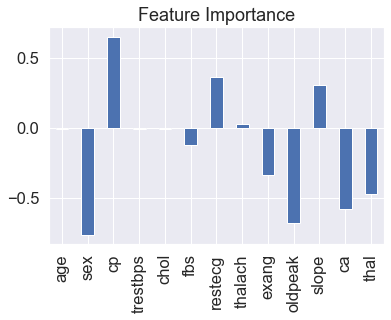

In [68]:
# visualize feature importance
feature_df = pd.DataFrame(feature_dict, index =[0])
feature_df.T.plot.bar(title = "Feature Importance", legend = False);


## Saving the Model

In [71]:
import pickle
 
# Save the trained model as a pickle string.
classification_model = pickle.dumps(gs_log_reg)
# Load the pickled model
gs_log_reg_from_pickle = pickle.loads(classification_model)
 
# Use the loaded pickled model to make predictions
gs_log_reg_from_pickle.predict(X_test)

array([1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1], dtype=int64)